In [1]:
# import all the libraries
import requests
import pytz
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from ipywidgets import interact, IntSlider
from datetime import datetime, timedelta

## Get Bitcoin price on a daily basis

This code block includes three functions for analyzing the opening price of Bitcoin on a daily basis:

- `get_start_end_per_day`: Returns the start and end time of a day given a date.
- `get_daily_price`: Fetches the daily opening price of BTC-USD from the Coinbase Pro API for a given date.
- `plot_price`: Plots the opening price of BTC-USD over time.

In [2]:
# Function to get the start and end time of a day, needed to input to Coinbase Pro API
def get_start_end_time(date=None):
    """
    Returns the start and end time of a day as datetime objects given a date.

    Args:
        date (datetime.date): The date to get the start and end time for (default is today's date).

    Returns:
        A tuple of two datetime objects: (start_time, end_time), where start_time is the start of the day
        as a datetime object, and end_time is the end of the day as a datetime object.
    """
    if date is None:
        date = datetime.date.today()

    # Get the start of the day as a datetime object
    midnight = datetime.datetime.combine(date, datetime.time.min)
    start_time = midnight

    # Get the end of the day as a datetime object
    end_time = datetime.datetime.combine(date, datetime.time.max)

    # If the date is today, set the end time to the current time in Eastern Time
    if date == datetime.date.today():
        eastern_tz = pytz.timezone('US/Eastern')
        et_now = datetime.datetime.now(eastern_tz)
        end_time = et_now

    return start_time, end_time


def get_daily_price(date=None):
    """
    Fetches the daily opening price of BTC-USD from the Coinbase Pro API for a given date.

    Args:
        date (datetime.date): The date to fetch the data for (default is today's date).

    Returns:
        A tuple of two lists: (time_data, open_prices), where time_data is a list of datetime objects representing
        the time of each data point, and open_prices is a list of floats representing the opening price at each data point.
    """
    url = "https://api.pro.coinbase.com/products/BTC-USD/candles"

    # Find the start and end time of a date
    if date is None:
        date = datetime.date.today()
    start_time, end_time = get_start_end_time(date)

    params = {
        "start": start_time.isoformat(),
        "end": end_time.isoformat(),
        "granularity": 300  # 5 minutes in seconds
    }

    response = requests.get(url, params=params)
    if response.status_code == 200:
        # Extract data from the API response
        data = response.json()
        if isinstance(data, list):
            time_data = [datetime.datetime.fromtimestamp(item[0]) for item in data]
            open_prices = [item[3] for item in data]
            return time_data, open_prices
        else:
            print("Error: Unexpected data format.")
            return None, None
    else:
        print("Error:", response.status_code)
        return None, None


In [5]:
import datetime

# Initialize the time and price lists
all_time_data = []
all_open_prices = []

# Fetch the Bitcoin price of the past 90 days
for i in range(90):
    # Calculate the date i days ago
    past_date = datetime.date.today() - datetime.timedelta(days=i)

    # Get the daily opening price of BTC-USD for the past_date
    time_data, open_prices = get_daily_price(past_date)

    # Append the fetched data to the lists
    if time_data is not None and open_prices is not None:
        all_time_data.extend(time_data)
        all_open_prices.extend(open_prices)

# Sort the data by time
sorted_data = sorted(zip(all_time_data, all_open_prices))
all_time_data, all_open_prices = zip(*sorted_data)


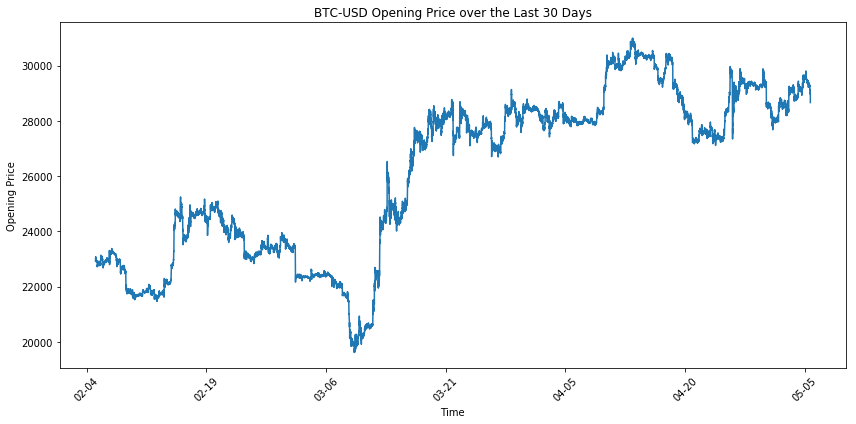

In [6]:
# Function to plot the price history
def plot_price(time, price, xlabel='Time', ylabel='Opening Price', title='BTC-USD Opening Price over the Last 24 Hours'):
    """
    Plots the opening price of BTC-USD over time.

    Args:
        time (array): An array of datetime objects representing the time of each data point.
        price (array): An array of floats representing the opening price at each data point.
        xlabel (str): The label for the x-axis (default is 'Time').
        ylabel (str): The label for the y-axis (default is 'Opening Price').
        title (str): The title of the plot (default is 'BTC-USD Opening Price over the Last 24 Hours').
    """
    # Validate inputs
    if len(time) != len(price):
        raise ValueError("The 'time' and 'price' arrays must have the same length.")

#     # Plot the data
#     plt.plot(time, price)
#     plt.xlabel(xlabel)
#     plt.ylabel(ylabel)
#     plt.title(title)

#     # Set the x-axis formatting
#     ax = plt.gca()
#     ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
#     ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=60*24*15))  # Display x-axis ticks for every 2 hours

     # Create the figure
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot the data
    ax.plot(time, price)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    # Set the x-axis formatting
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=60*24*15))  # Display x-axis ticks for every 2 hours


    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    
# Plot the time vs price data
plot_price(all_time_data, all_open_prices, title='BTC-USD Opening Price over the Last 30 Days')
    

In [10]:
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

def interactive_plot_price(time, price):
    def plot(zoom_level, x_pan):
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(time, price)
        ax.set_xlabel('Time')
        ax.set_ylabel('Opening Price')
        ax.set_title('BTC-USD Opening Price over the Last 30 Days')

        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
        ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=120))

        # Set plot limits
        time_min = time[0] + datetime.timedelta(minutes=x_pan * zoom_level)
        time_max = time_min + datetime.timedelta(minutes=zoom_level * 100)
        ax.set_xlim(time_min, time_max)
        
        # Update y-axis limits based on visible data
        visible_data = [price_value for time_value, price_value in zip(time, price) if time_min <= time_value <= time_max]
        if visible_data:
            y_min, y_max = min(visible_data), max(visible_data)
            margin = (y_max - y_min) * 0.1
            ax.set_ylim(y_min - margin, y_max + margin)

        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    # Create interactive sliders
    zoom_level_slider = IntSlider(min=5, max=1000, step=5, value=300, description='Zoom Level:')
    x_pan_slider = IntSlider(min=0, max=len(time) - 1, step=1, value=len(time) // 2, description='X Pan:')

    interact(plot, zoom_level=zoom_level_slider, x_pan=x_pan_slider)


In [11]:
interactive_plot_price(all_time_data, all_open_prices)

interactive(children=(IntSlider(value=300, description='Zoom Level:', max=1000, min=5, step=5), IntSlider(valu…